In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm

%matplotlib inline

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

# System libraries
from pathlib import Path
import os.path
import random
import cv2

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

### Helper Function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-09-25 17:32:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-25 17:32:33 (58.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Data Preprocessing

In [3]:
PATH = '../input/4-animal-classification'
train_path = os.path.join(PATH, 'train/')
test_path = os.path.join(PATH, 'test/')

In [4]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)


In [6]:

train_dataset = train_generator.flow_from_directory(
    train_path,
    subset='training',
    target_size = IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=45,
)

Found 2240 images belonging to 4 classes.


In [7]:
val_dataset = train_generator.flow_from_directory(
    train_path,
    subset='validation',
    target_size = IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=45,
)

Found 560 images belonging to 4 classes.


#### Visualisasi

In [8]:
class_names = os.listdir(train_path)
print(class_names)

['horse', 'dog', 'cat', 'deer']


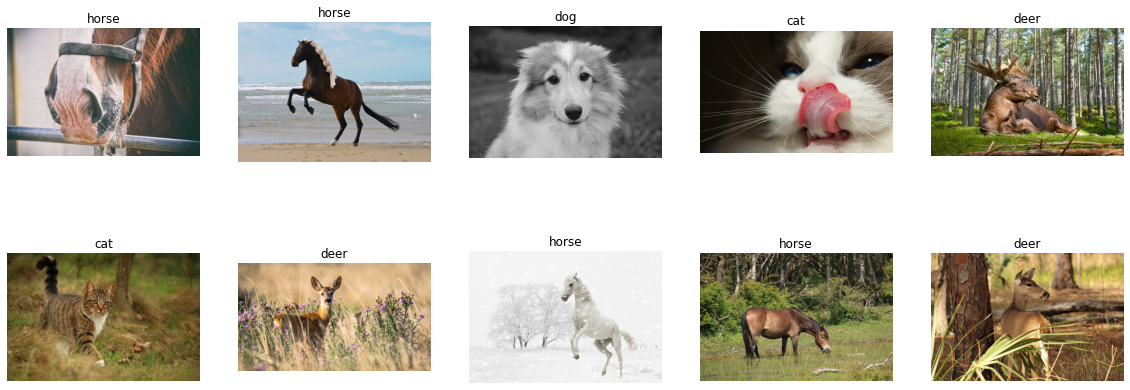

In [9]:
plt.figure(figsize=(20, 20))

for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(train_path + class_names[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread(train_path+ class_names[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(class_names[i])
    plt.axis("off")

plt.show()

In [10]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2022-09-25 17:32:35.060806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 17:32:35.159589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 17:32:35.160442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 17:32:35.162350: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Training model

In [11]:

pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

17620992/17605208 [==============================] - 0s 0us/step


In [12]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [13]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

### Training Model

In [14]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animal_classification"),
        checkpoint_callback,
    ]
)

2022-09-25 17:32:39.668866: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-25 17:32:39.668912: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-25 17:32:39.670607: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-09-25 17:32:39.885330: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-25 17:32:39.885523: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: training_logs/animal_classification/20220925-173239


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-09-25 17:32:40.510677: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-09-25 17:32:45.188943: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/70 [..............................] - ETA: 11:46 - loss: 1.4806 - accuracy: 0.2188

2022-09-25 17:32:50.891599: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-25 17:32:50.891646: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/70 [..............................] - ETA: 29s - loss: 1.4800 - accuracy: 0.2344  

2022-09-25 17:32:51.220528: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-25 17:32:51.221334: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-25 17:32:51.371609: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 456 callback api events and 453 activity events. 
2022-09-25 17:32:51.392998: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 3/70 [>.............................] - ETA: 26s - loss: 1.4538 - accuracy: 0.2500

2022-09-25 17:32:51.425443: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/animal_classification/20220925-173239/train/plugins/profile/2022_09_25_17_32_51

2022-09-25 17:32:51.438821: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/animal_classification/20220925-173239/train/plugins/profile/2022_09_25_17_32_51/6f6f1ec5df4a.trace.json.gz
2022-09-25 17:32:51.496869: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/animal_classification/20220925-173239/train/plugins/profile/2022_09_25_17_32_51

2022-09-25 17:32:51.506009: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to training_logs/animal_classification/20220925-173239/train/plugins/profile/2022_09_25_17_32_51/6f6f1ec5df4a.memory_profile.json.gz
2022-09-25 17:32:51.508026: I tensorflow/core/profiler/rpc/client/capt

70/70 [==============================] - 42s 454ms/step - loss: 1.3852 - accuracy: 0.3406 - val_loss: 1.2339 - val_accuracy: 0.4946
Epoch 2/100
70/70 [==============================] - 20s 284ms/step - loss: 1.1788 - accuracy: 0.5205 - val_loss: 1.0564 - val_accuracy: 0.6893
Epoch 3/100
70/70 [==============================] - 21s 296ms/step - loss: 1.0108 - accuracy: 0.6674 - val_loss: 0.9080 - val_accuracy: 0.8107
Epoch 4/100
70/70 [==============================] - 20s 289ms/step - loss: 0.8644 - accuracy: 0.7634 - val_loss: 0.7812 - val_accuracy: 0.8732
Epoch 5/100
70/70 [==============================] - 20s 286ms/step - loss: 0.7393 - accuracy: 0.8321 - val_loss: 0.6728 - val_accuracy: 0.8946
Epoch 6/100
70/70 [==============================] - 21s 295ms/step - loss: 0.6382 - accuracy: 0.8710 - val_loss: 0.5828 - val_accuracy: 0.9054
Epoch 7/100
70/70 [==============================] - 20s 293ms/step - loss: 0.5579 - accuracy: 0.8955 - val_loss: 0.5074 - val_accuracy: 0.9232
Epoc

In [15]:
results = model.evaluate(val_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.09932
Test Accuracy: 97.14%


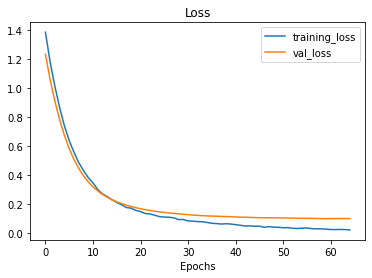

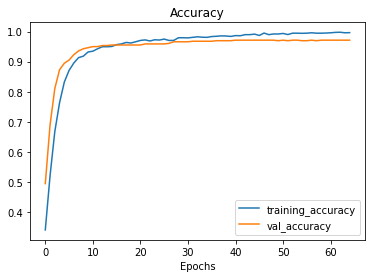

In [16]:
plot_loss_curves(history)

In [17]:
model.evaluate(val_dataset)

18/18 [==============================] - 4s 230ms/step - loss: 0.0993 - accuracy: 0.9714


[0.09931958466768265, 0.9714285731315613]

In [18]:
model.save('mobileNet3.h5')

### Testing

In [19]:
# load model
new_model = keras.models.load_model('mobileNet3.h5')


In [20]:
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
)

test_dataset = train_generator.flow_from_directory(
    test_path,
    target_size = IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 729 images belonging to 1 classes.


In [21]:
predict = model.predict(test_dataset)
predict = np.argmax(predict,axis=1)

# Map the label
labels = (train_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predict = [labels[k] for k in predict]

# Display the result
print(f'The first 5 predictions: {predict[:5]}')

The first 5 predictions: ['deer', 'dog', 'cat', 'cat', 'horse']


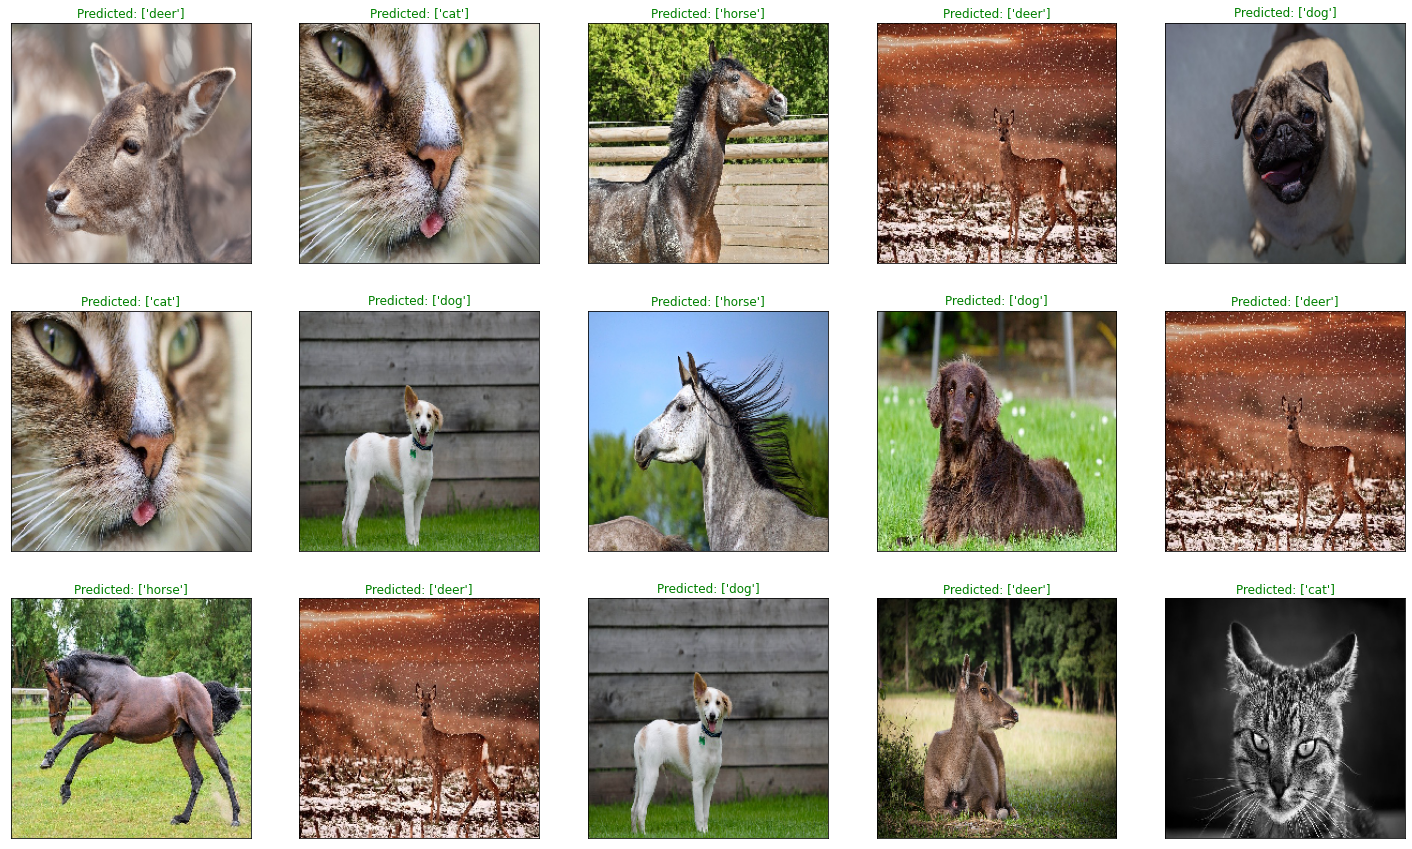

<Figure size 432x288 with 0 Axes>

In [ ]:
from keras.preprocessing import image

random_index = np.random.randint(1, len(test_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = load_img(test_path+'test/'+str(random_index[i])+'.jpg', target_size=(224, 224))
    ax.imshow(img)
    img = image.img_to_array(img)
    img_arr = np.expand_dims(img, 0)
    img_arr = tf.keras.applications.mobilenet_v3.preprocess_input(img_arr)
    pred = new_model.predict(img_arr)
    
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_dataset.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    ax.set_title(f"Predicted: {pred}", color='white')
plt.show()
plt.tight_layout()

### Preparing for submission

In [27]:
sub_csv ='../input/4-animal-classification/Sample_submission.csv'
path_test = '../input/4-animal-classification/test/test'

In [28]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [29]:
img = image.load_img('../input/4-animal-classification/test/test/1.jpg', target_size=(224, 224))
img = image.img_to_array(img)
img_arr = np.expand_dims(img, 0)
img_arr = tf.keras.applications.mobilenet_v3.preprocess_input(img_arr)
label = model.predict(img_arr)

In [30]:
np.argmax(label,axis=1)


array([1])

In [31]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

# making a list for our predictions
labels = []


for i in image_id:
    img = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = image.img_to_array(img)
    img_arr = np.expand_dims(img, 0)
    img_arr = tf.keras.applications.mobilenet_v3.preprocess_input(img_arr)
    label = model.predict(img_arr)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))

In [32]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(30)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [33]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)

In [34]:
df = pd.read_csv('./submission_file.csv')
df.head()

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
